In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import soundfile as sf
from pathlib import Path
from tqdm.notebook import tqdm
from scipy.signal import stft
from random import uniform, sample
from pyroomacoustics import doa, Room, ShoeBox

In [26]:
import alphaMusic.utils.acu_utils as acu
from alphaMusic.alphaMUSIC import AlphaMUSIC, aMUSIC

In [145]:
fs = 16000 
nfft = 1024
n = 5*fs # simulation length of source signal (3 seconds)
n_frames = 30
max_order = 30
doas_deg = np.linspace(start=0, stop=180, num=10, endpoint=True)
rs = [1, 1.5, 2]
mic_center = np.c_[[2,2,1]]
mic_locs = mic_center + acu.get_echo_array(5, 0.04).mic_pos
snr_lb, snr_ub = 0, 30

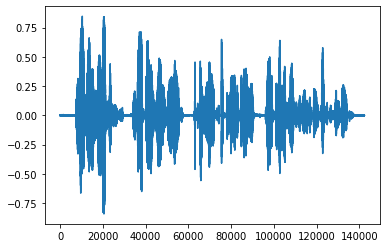

(142320,)


In [146]:
path = '../data/LibriSpeech/dev-clean/1673/143397/1673-143397-0001.flac'
path_to_speech = Path(path)
speech, fs = sf.read(path_to_speech)
plt.plot(speech)
plt.show()
print(speech.shape)

In [147]:
# room simulation
data = []
for source in ['noise', 'speech']:
    for r in tqdm(rs):
        for i, doa_deg in enumerate(tqdm(doas_deg)):
            doa_rad = np.deg2rad(doa_deg)
            source_loc = mic_center[:,0] + np.c_[r*np.cos(doa_rad), r*np.sin(doa_rad), 0][0]
            room_dim = [uniform(4,6), uniform(4,6), uniform(2, 4)] # meters

            room = ShoeBox(room_dim, fs=fs, max_order=max_order, absorption=0.2)
            if source == 'speech': signal = speech[:n]
            if source == 'noise' : signal = np.random.random(n)
                
            room.add_source(source_loc, signal=speech)
            room.add_microphone_array(mic_locs)
            snr = uniform(snr_lb, snr_ub)
            room.simulate(snr=snr)
            signals = room.mic_array.signals

            # calculate n_frames stft frames starting at 1 second
            stft_signals = stft(signals[:,fs:fs+n_frames*nfft], fs=fs, nperseg=nfft, noverlap=0, boundary=None)[2]
            data.append([source,r,snr, doa_deg, stft_signals])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [148]:
kwargs = {'L': mic_locs,
          'fs': fs, 
          'nfft': nfft,
          'azimuth': np.deg2rad(np.arange(180))
}
algorithms = {
    'MUSIC': doa.music.MUSIC(**kwargs),
    'aMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=False),
    'aMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=False),
    'aMUSIC_gau' : aMUSIC(**kwargs,alpha=2,frequency_normalization=False),
    'aMUSIC_tyl' : aMUSIC(**kwargs,alpha=0,frequency_normalization=False),
    'NormMUSIC': doa.normmusic.NormMUSIC(**kwargs),
    'aNormMUSIC_est' : aMUSIC(**kwargs,alpha=3,frequency_normalization=True),
    'aNormMUSIC_fix' : aMUSIC(**kwargs,alpha=1.5,frequency_normalization=True),
    'aNormMUSIC_gau' : aMUSIC(**kwargs,alpha=2,frequency_normalization=True),
    'aNormMUSIC_tyl' : aMUSIC(**kwargs,alpha=0,frequency_normalization=True),
    
}
columns = ["source", "r", "snr", "DOA", 'algo', "DOAest"]

In [149]:
predictions = {n:[] for n in columns}

for source, r, snr, doa_deg, stft_signals in tqdm(data):

    for algo_name, algo in algorithms.items():

        snr = 10*int(snr / 10)
        
        predictions['source'].append(source)
        predictions['r'].append(r)
        predictions['snr'].append(snr)
        predictions['DOA'].append(doa_deg)
        predictions['algo'].append(algo_name)
        
#         if algo_name == "aMUSIC":
#             stft_signals = stft_signals.transpose([1,2,0])
#             print(doa_deg, snr)

        algo.locate_sources(stft_signals, freq_range=[500.0, 4000.0])
        doa_est = np.rad2deg(algo.azimuth_recon[0])
        predictions['DOAest'].append(doa_est)
#         print(doa_est)

df = pd.DataFrame.from_dict(predictions)

  0%|          | 0/60 [00:00<?, ?it/s]

In [150]:
pd.set_option("display.max_rows", 40)
df.head(40)

,source,r,snr,DOA,algo,DOAest
0,noise,1.0,0,0.0,MUSIC,0.0
1,noise,1.0,0,0.0,aMUSIC_est,0.0
2,noise,1.0,0,0.0,aMUSIC_fix,0.0
3,noise,1.0,0,0.0,aMUSIC_gau,0.0
4,noise,1.0,0,0.0,aMUSIC_tyl,3.0
5,noise,1.0,0,0.0,NormMUSIC,0.0
6,noise,1.0,0,0.0,aNormMUSIC_est,0.0
7,noise,1.0,0,0.0,aNormMUSIC_fix,0.0
8,noise,1.0,0,0.0,aNormMUSIC_gau,0.0
9,noise,1.0,0,0.0,aNormMUSIC_tyl,0.0


In [151]:
MAE, MEDAE = {}, {}

def calc_ae(a,b):
    x = np.abs(a-b)
    return np.min(np.array((x, np.abs(360-x))), axis=0)

for algo_name in algorithms.keys():
        
    curr_df = df.loc[df['algo'] == algo_name]
    
    ae = calc_ae(curr_df.loc[:,["DOA"]].to_numpy(), 
                 curr_df.loc[:,["DOAest"]].to_numpy())
    MAE[algo_name] = np.mean(ae)
    MEDAE[algo_name] = np.median(ae)
    
err = calc_ae(df.loc[:,["DOA"]].to_numpy(), df.loc[:,["DOAest"]].to_numpy()).squeeze()
df['Err'] = err

<AxesSubplot:title={'center':'speech'}, xlabel='r', ylabel='Err'>

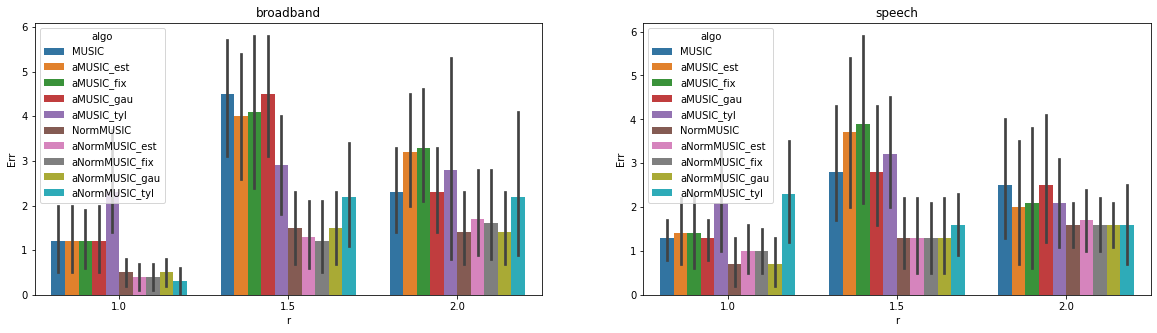

In [152]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('broadband')
sns.barplot(x='r',y='Err', hue='algo', data=df.loc[df['source'] == 'noise'])
plt.subplot(122)
plt.title('speech')
sns.barplot(x='r',y='Err', hue='algo', data=df.loc[df['source'] == 'speech'])

<AxesSubplot:title={'center':'speech'}, xlabel='r', ylabel='Err'>

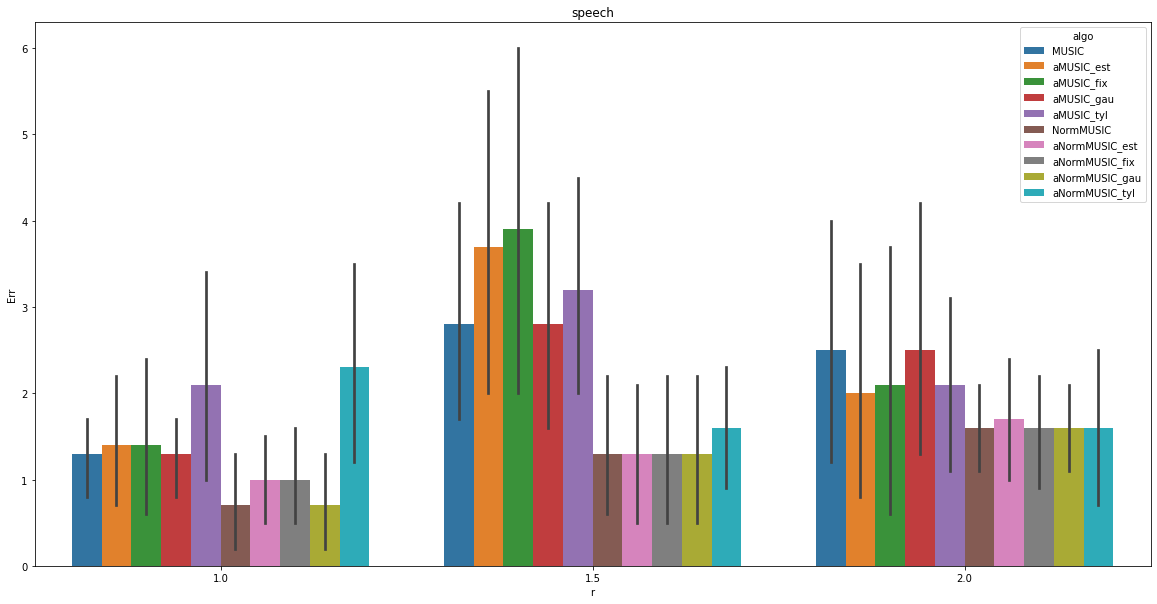

In [153]:
plt.figure(figsize=(20,10))
plt.title('speech')
sns.barplot(x='r',y='Err', hue='algo', data=df.loc[df['source'] == 'speech'])

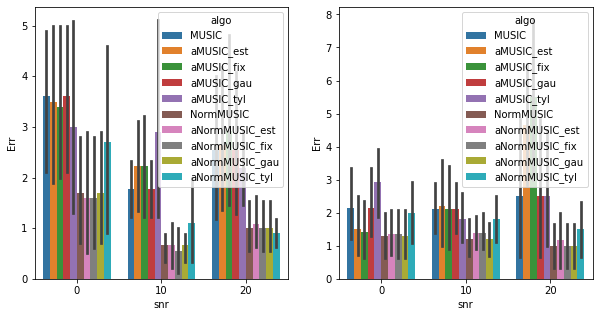

In [154]:
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.barplot(x='snr',y='Err', hue='algo', data=df.loc[df['source'] == 'noise'])
plt.subplot(122)
sns.barplot(x='snr',y='Err', hue='algo', data=df.loc[df['source'] == 'speech'])
plt.show()

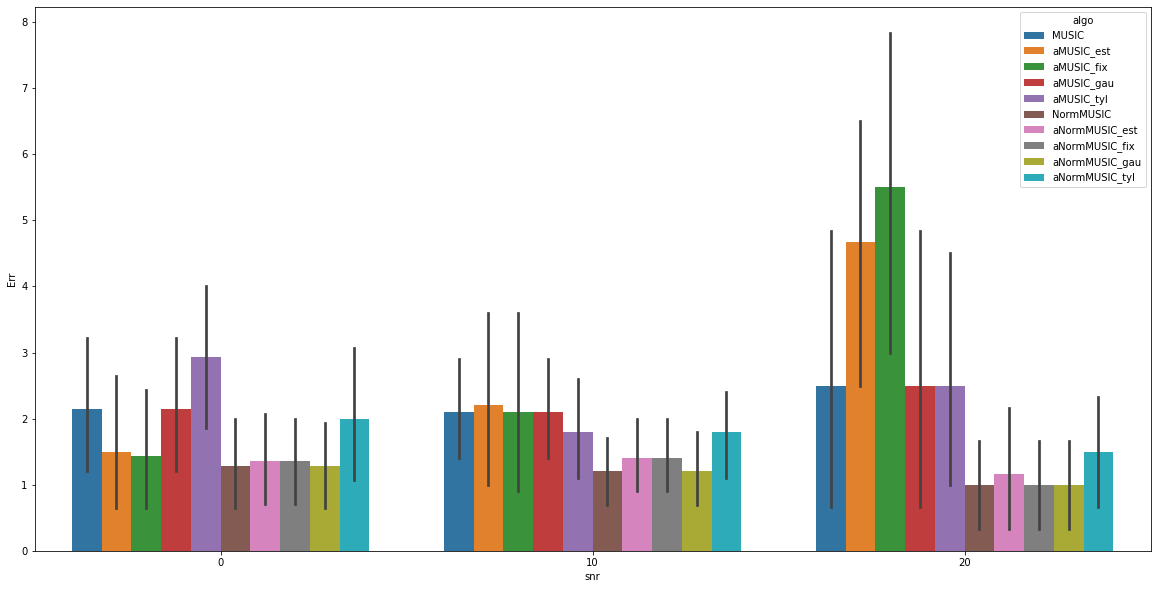

In [155]:
plt.figure(figsize=(20,10))
sns.barplot(x='snr',y='Err', hue='algo', data=df.loc[df['source'] == 'speech'])
plt.show()

<AxesSubplot:xlabel='DOA', ylabel='DOAest'>

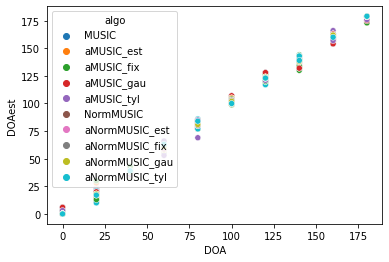

In [156]:
sns.scatterplot(x='DOA',y='DOAest', hue='algo', data=df)